<a href="https://colab.research.google.com/github/pfauda/angular-flex-and-tabs/blob/master/cll_porcentajes_de_cambio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Graficador de activos en CCL de Galicia

In [2]:
# Instalación de librerias

In [8]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 15.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=1ab3d38af5d7c48f237fb1dbaf14305e8f2f90abe699fbfb70722966f03240b1
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [66]:
# Importar las librerias de python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import files

In [119]:
#@title Parámetros de ejecución
Inicio = "2000-01-03" #@param {type:"date"}
Fin = "2021-01-03" #@param {type:"date"}
Variable = "Close" #@param ["Close", "Adj Close"]
start = Inicio
end = Fin
calc = Variable

In [147]:
# Cargar datos historicos
import yfinance as yf
import datetime as dt
#start = "2014-01-01"
#end = "2001-12-31"
#end = dt.date.today().strftime("%Y-%m-%d")
df_ccl_data = yf.download(['GGAL','GGAL.BA','YPF','YPFD.BA','PAM','PAMP.BA'], start=start, end=end)[Variable]
df_ccl_pond =  df_ccl_data['YPFD.BA']/df_ccl_data['YPF']
df_ccl_pond += df_ccl_data['GGAL.BA']/df_ccl_data['GGAL'] * 10
#df_ccl_pond += df_ccl_data['PAMP.BA']/df_ccl_data['PAM'] * 25
df_ccl_pond /= 2
df_ccl_pond = df_ccl_pond.to_frame()

[*********************100%***********************]  6 of 6 completed


In [148]:
df_ccl_pond.rename(columns={ df_ccl_pond.columns[0]: Variable }, inplace = True)

In [149]:
# Podar los outliers
close = df_ccl_pond['Close']
removed_ol = close.between(close.quantile(.002), close.quantile(.998))
df_ccl_pond = df_ccl_pond[removed_ol] # without outliers
# Interpolar los valores eliminados y faltantes
df_ccl_pond.pad(inplace=True)

In [150]:
# Suavizarla un poco
#df_ccl_ggal = df_ccl_ggal.shift(-2).rolling(5, 1, ).mean()

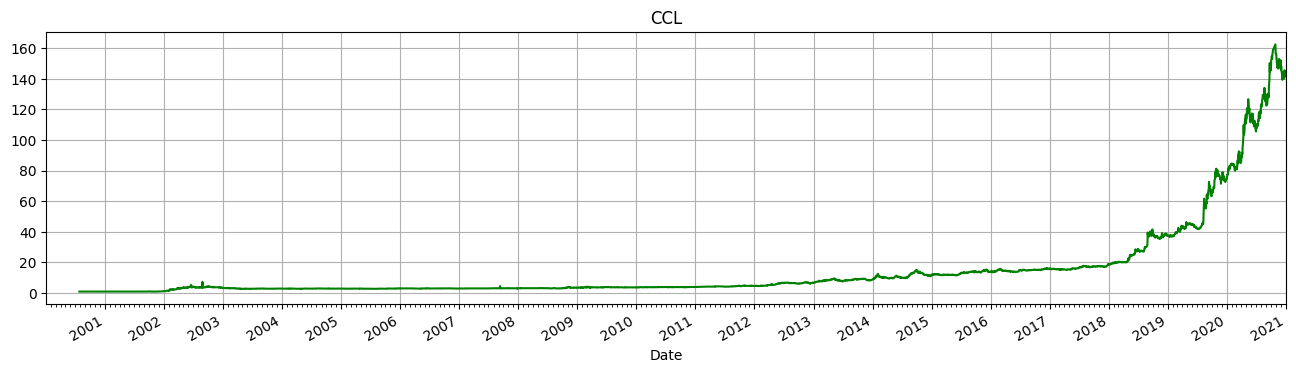

In [151]:
# Graficar la serie
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
ax1=df_ccl_pond[Variable].plot(ax=axes, color='green')
# format the ticks
ax1.set_title("CCL")
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xlim(np.datetime64(start), np.datetime64(end))
ax1.grid(True)
plt.show()

In [156]:
def plot_ticker(ticker):
  # Graficar el ticker local en CCL
  df_ticker_local = yf.download(ticker, start=start, end=end)[Variable]
  if not df_ticker_local.empty:
    df_ticker_local = df_ticker_local.to_frame()
    df_ticker_local.rename(columns={ df_ticker_local.columns[0]: Variable }, inplace = True)
    #if Variable == "Close":
    #  df_ticker_local.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)
    #else:
    #  df_ticker_local.drop(["Open", "High", "Low", "Close", "Volume"], axis=1, inplace=True)
    # Calcular el ticker en CCL
    df_ticker_ccl = df_ticker_local / df_ccl_pond
    # Si ubiera valores vacios tomar el ultimo
    df_ticker_ccl = df_ticker_ccl.pad()
    # Calcular el ajuste del cierre
    df_ticker_ccl.loc[df_ticker_ccl[Variable].diff() >= 0, 'Delta'] = (df_ticker_ccl[Variable] / df_ticker_ccl[Variable].shift(1) - 1)*100
    df_ticker_ccl.loc[df_ticker_ccl[Variable].diff() < 0, 'Delta'] = -(df_ticker_ccl[Variable].shift(1) / df_ticker_ccl[Variable] - 1)*100
    # Borrar la columna Adj Close y renombrar la columna Delta como Adj CLose
    df_ticker_ccl.drop(Variable,  axis='columns', inplace=True)
    df_ticker_ccl.rename({'Delta': Variable}, axis=1, inplace=True)
    # Obtener el acumulado de los porcentajes
    df_ticker_ccl[Variable] = df_ticker_ccl[Variable].cumsum()
    df_ticker_ccl[Variable] = df_ticker_ccl[Variable].fillna(0)

    ## Podar los outliers
    #Adj close = df_ticker_ccl["Adj Close"]
    #removed_ol = Adj close.between(Adj close.quantile(.02), Adj close.quantile(.98))
    #df_ticker_ccl = df_ticker_ccl[removed_ol] # without outliers
    ## Interpolar los valores eliminados
    #df_ticker_ccl.pad(inplace=True)

    # Borrar los datos nulos
    df_ticker_ccl.dropna(inplace=True)

    # Graficar la serie
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots()
    ax.plot(df_ticker_ccl)
    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.set_xlim(np.datetime64(start), np.datetime64(end))
    ax.grid(True)
    plt.rcParams['figure.figsize'] = [20, 3]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but 
    plt.title(ticker)
    #plt.savefig(ticker+".png")
    plt.show()

  return df_ticker_ccl

[*********************100%***********************]  1 of 1 completed


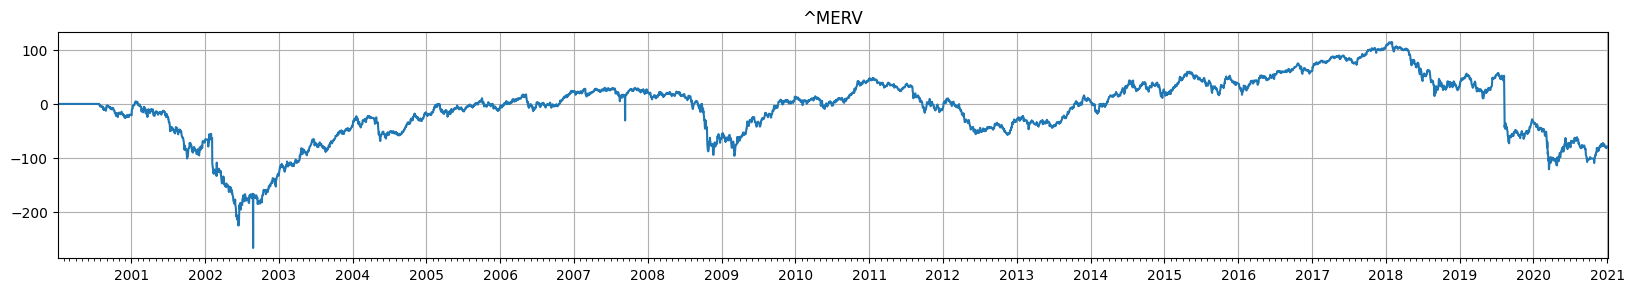

[*********************100%***********************]  1 of 1 completed


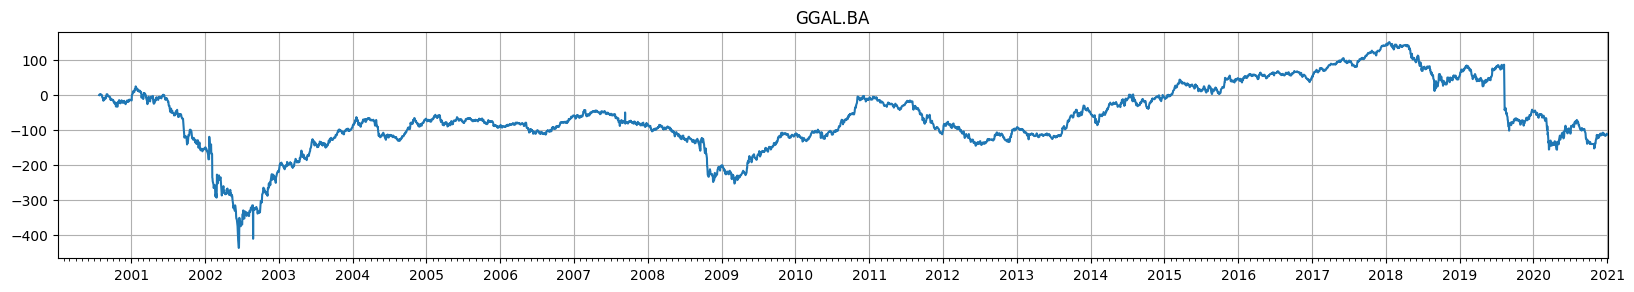

[*********************100%***********************]  1 of 1 completed


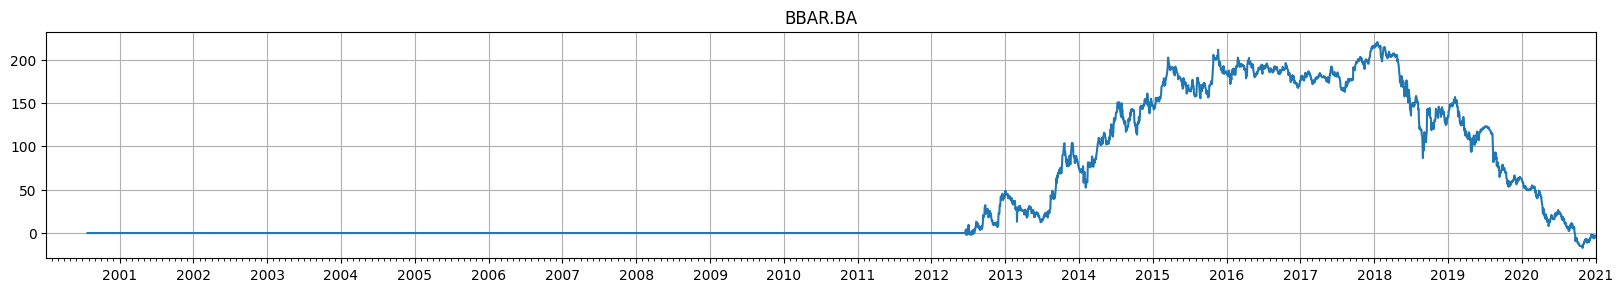

[*********************100%***********************]  1 of 1 completed


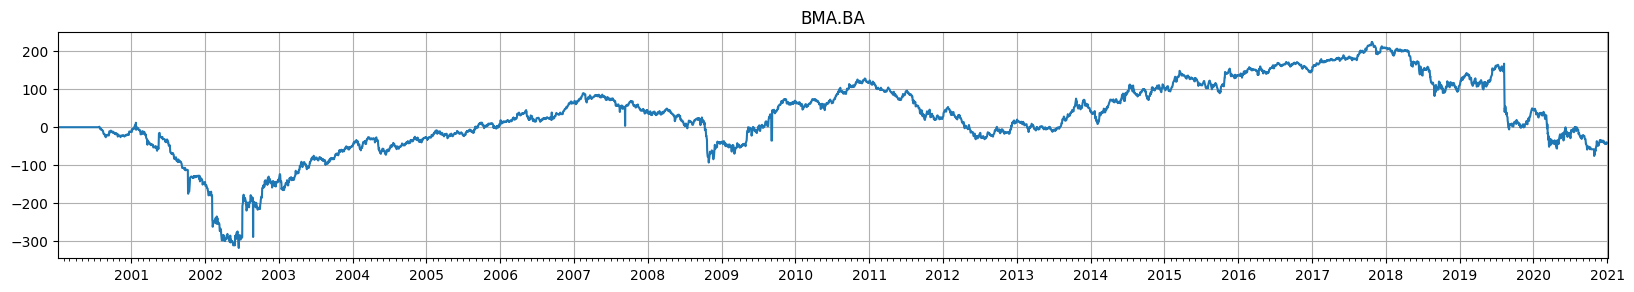

[*********************100%***********************]  1 of 1 completed


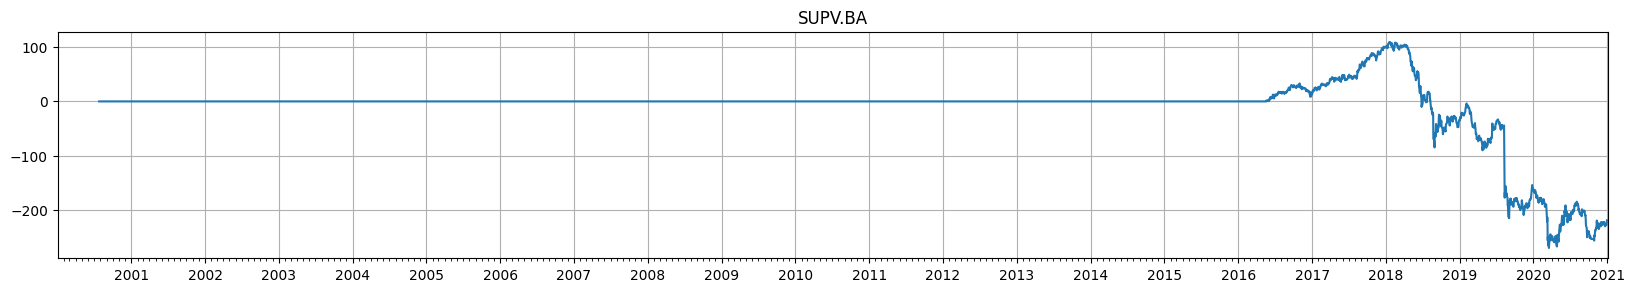

[*********************100%***********************]  1 of 1 completed


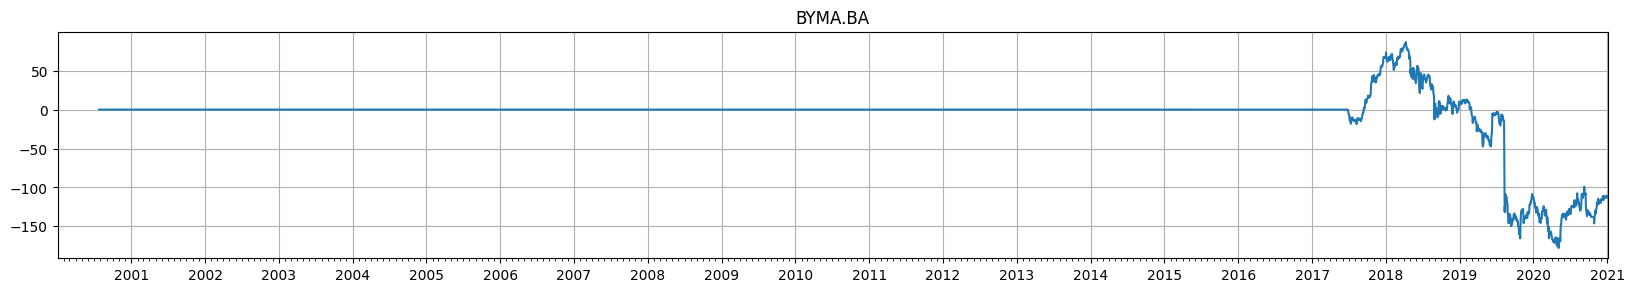

[*********************100%***********************]  1 of 1 completed


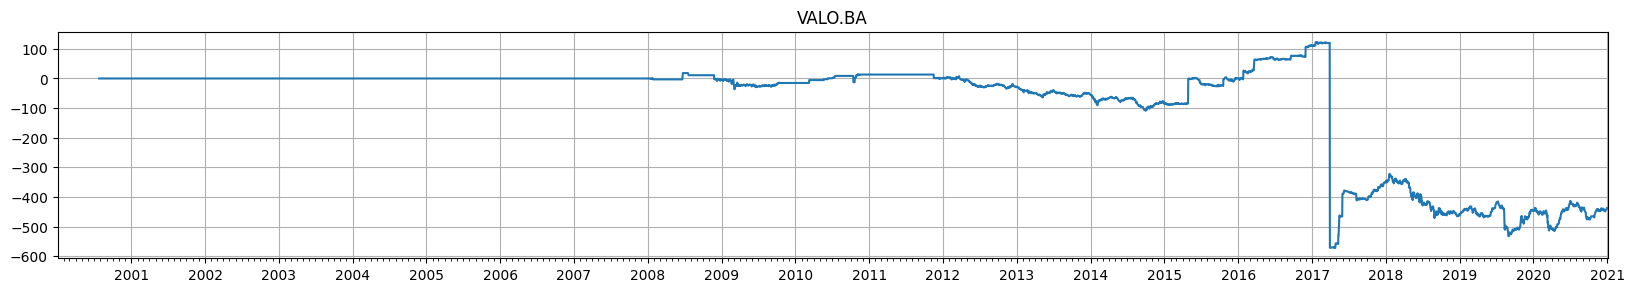

[*********************100%***********************]  1 of 1 completed


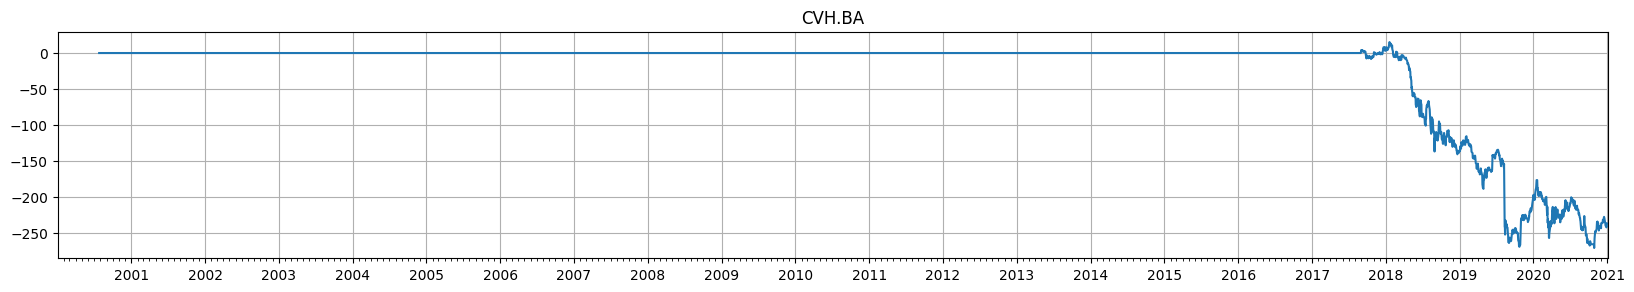

[*********************100%***********************]  1 of 1 completed


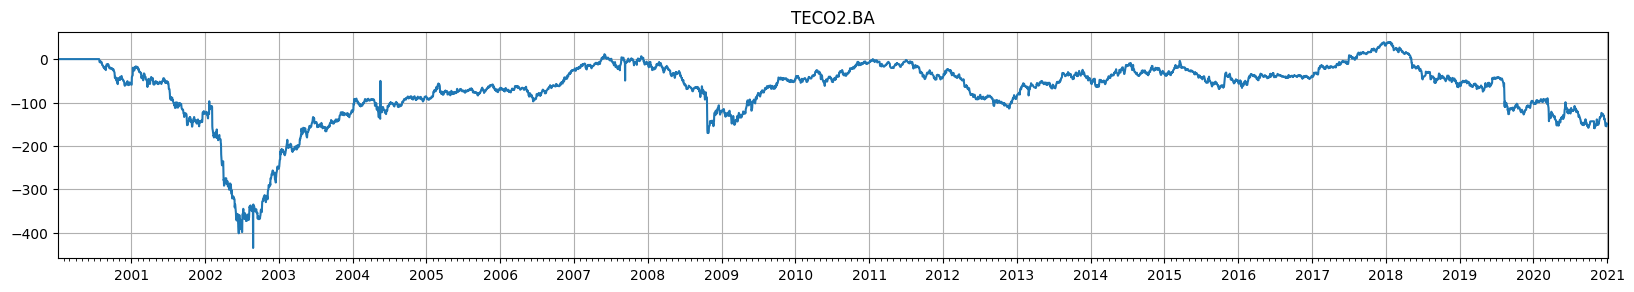

[*********************100%***********************]  1 of 1 completed


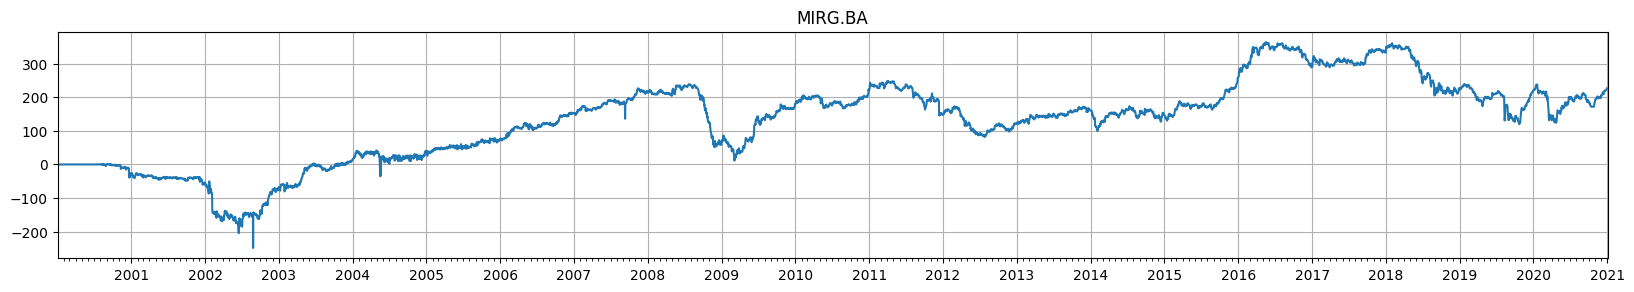

[*********************100%***********************]  1 of 1 completed


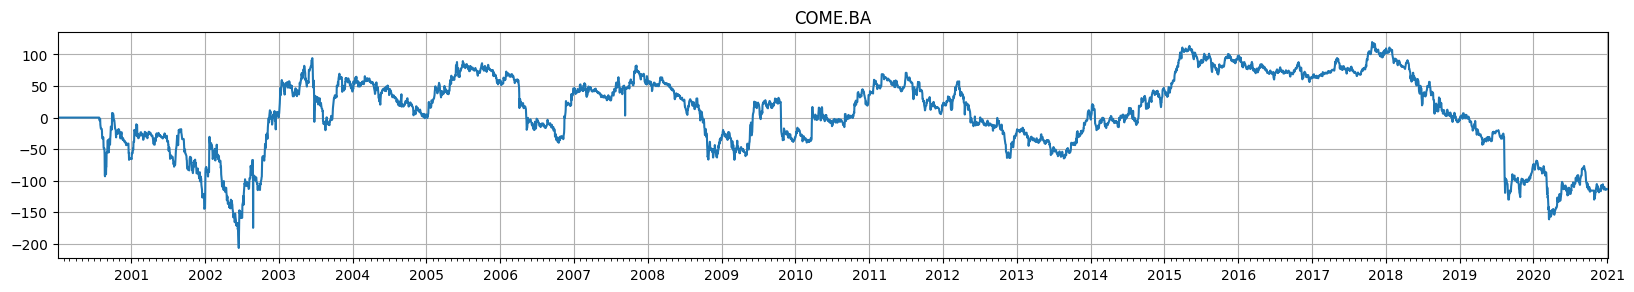

[*********************100%***********************]  1 of 1 completed


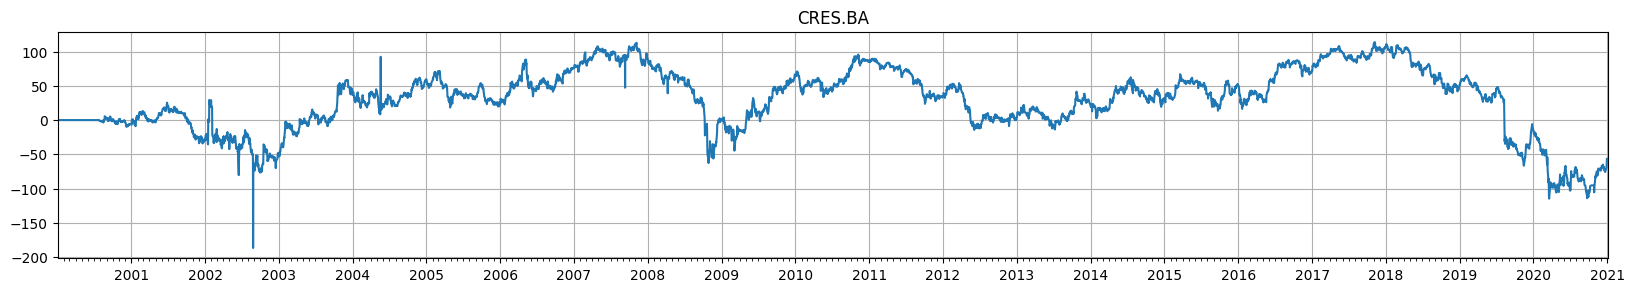

[*********************100%***********************]  1 of 1 completed


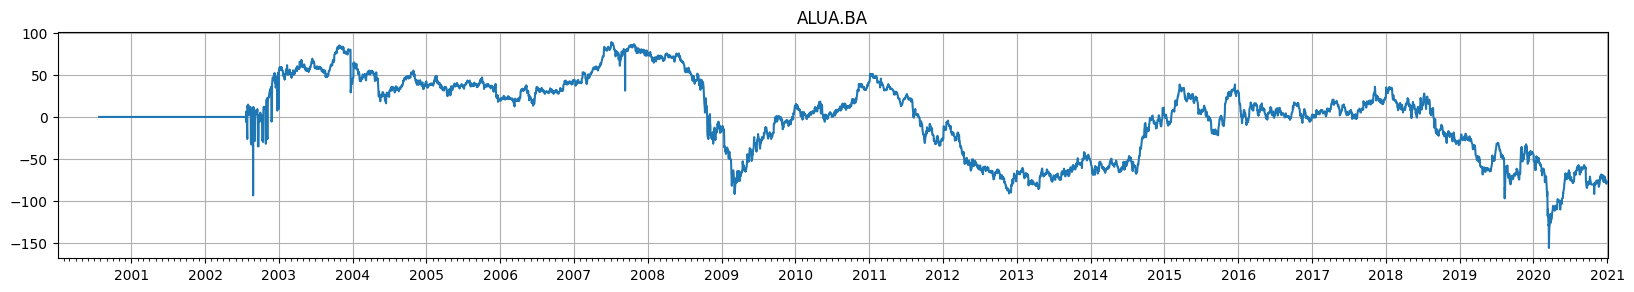

[*********************100%***********************]  1 of 1 completed


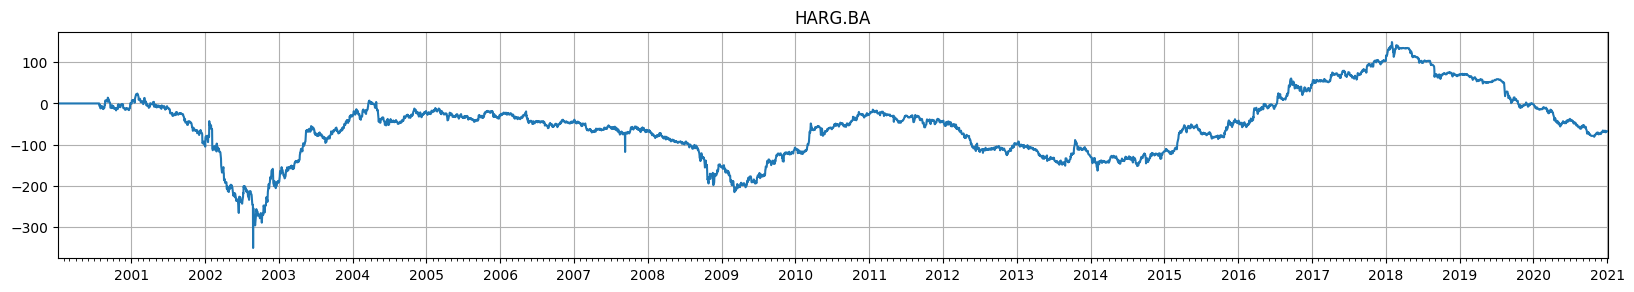

[*********************100%***********************]  1 of 1 completed


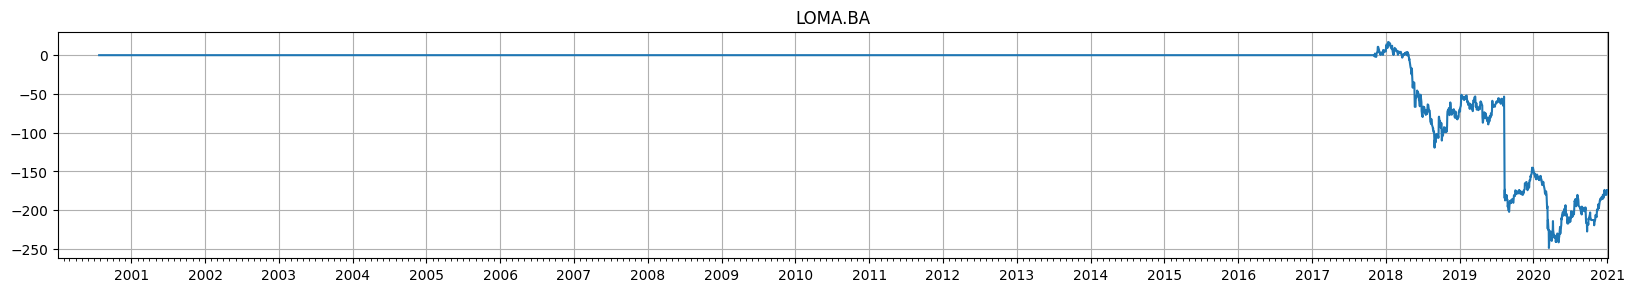

[*********************100%***********************]  1 of 1 completed


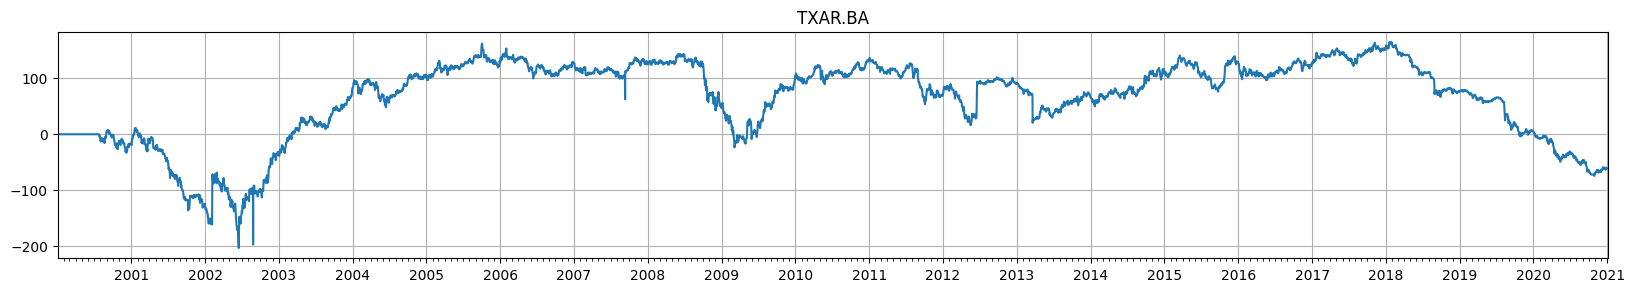

[*********************100%***********************]  1 of 1 completed


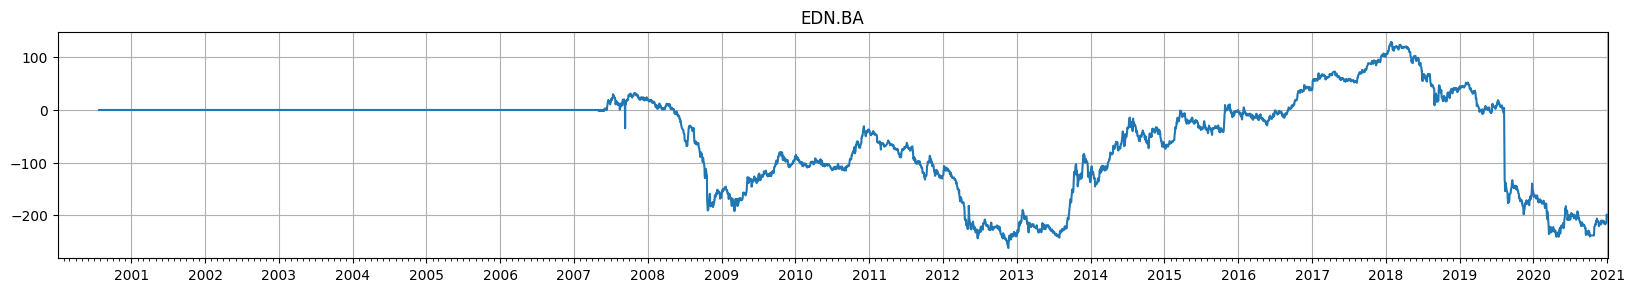

[*********************100%***********************]  1 of 1 completed


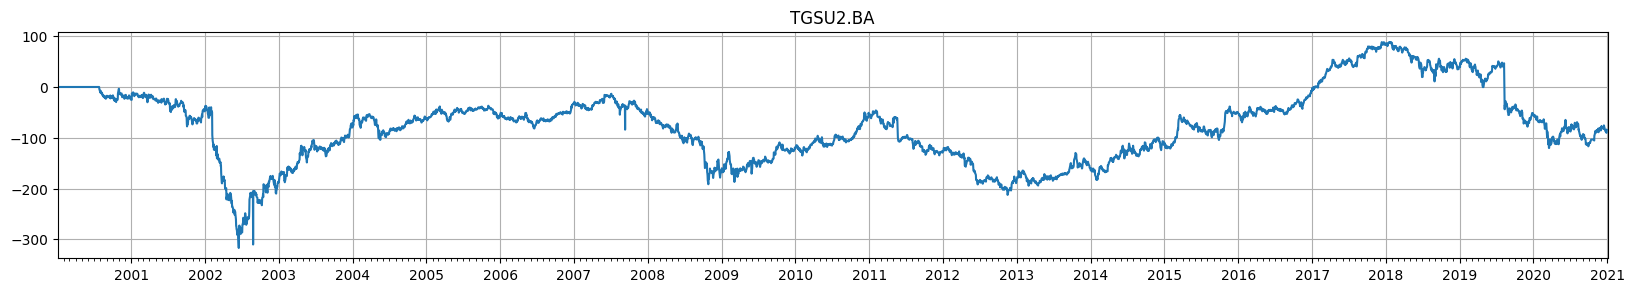

[*********************100%***********************]  1 of 1 completed


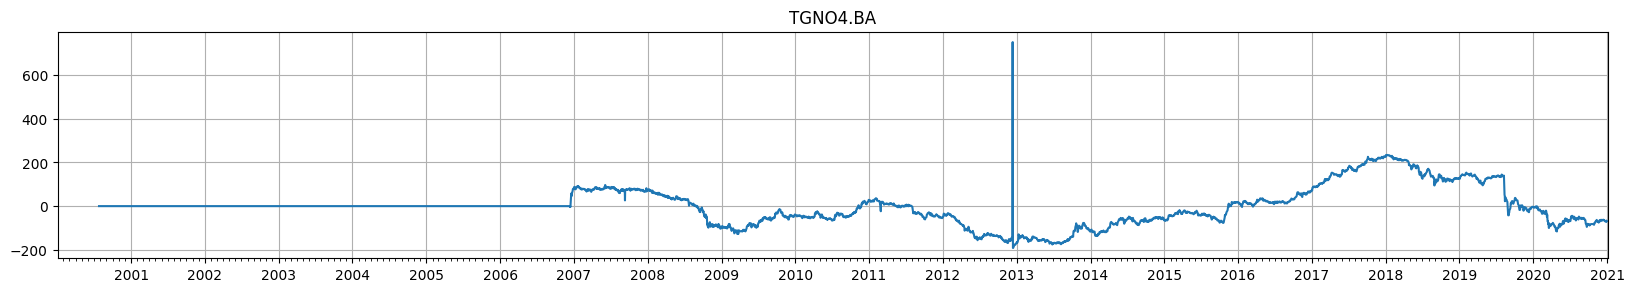

[*********************100%***********************]  1 of 1 completed


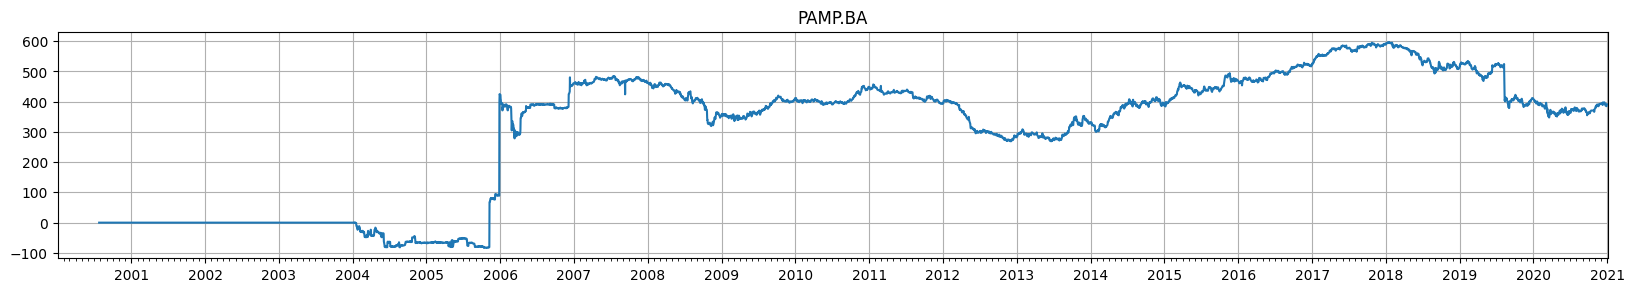

[*********************100%***********************]  1 of 1 completed


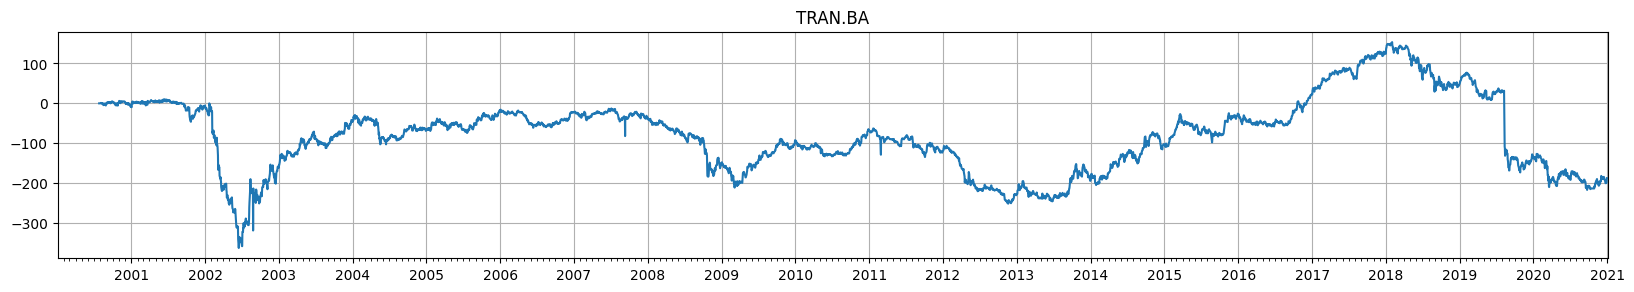

[*********************100%***********************]  1 of 1 completed


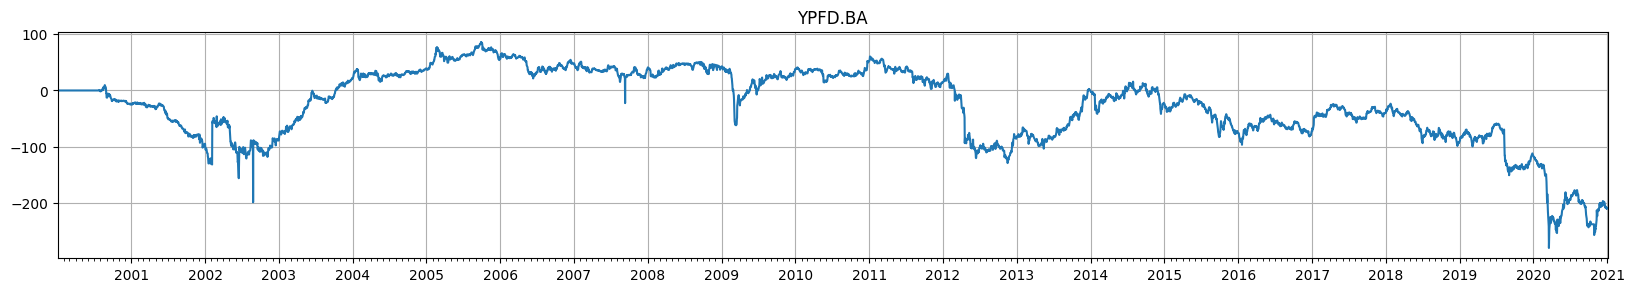

In [157]:
panel_lider = ["^MERV",
               "GGAL.BA", "BBAR.BA", "BMA.BA", "SUPV.BA", "BYMA.BA", "VALO.BA",
               "CVH.BA", "TECO2.BA", "MIRG.BA", "COME.BA",
               "CRES.BA",
               "ALUA.BA", "HARG.BA", "LOMA.BA", "TXAR.BA",  
               "EDN.BA", "TGSU2.BA", "TGNO4.BA", "PAMP.BA", "TRAN.BA", "YPFD.BA"]
#"CEPU.BA", 
#panel_lider = ["^MERV", "CRES.BA"]
#panel_lider = ["ALUA.BA"]
df_ccl = pd.DataFrame()
for t in panel_lider:
  df_ticker = plot_ticker(t)
  df_ticker.rename(columns={Variable: t}, inplace=True)
  df_ccl = df_ccl.merge(df_ticker, right_index=True, left_index=True, how="outer")

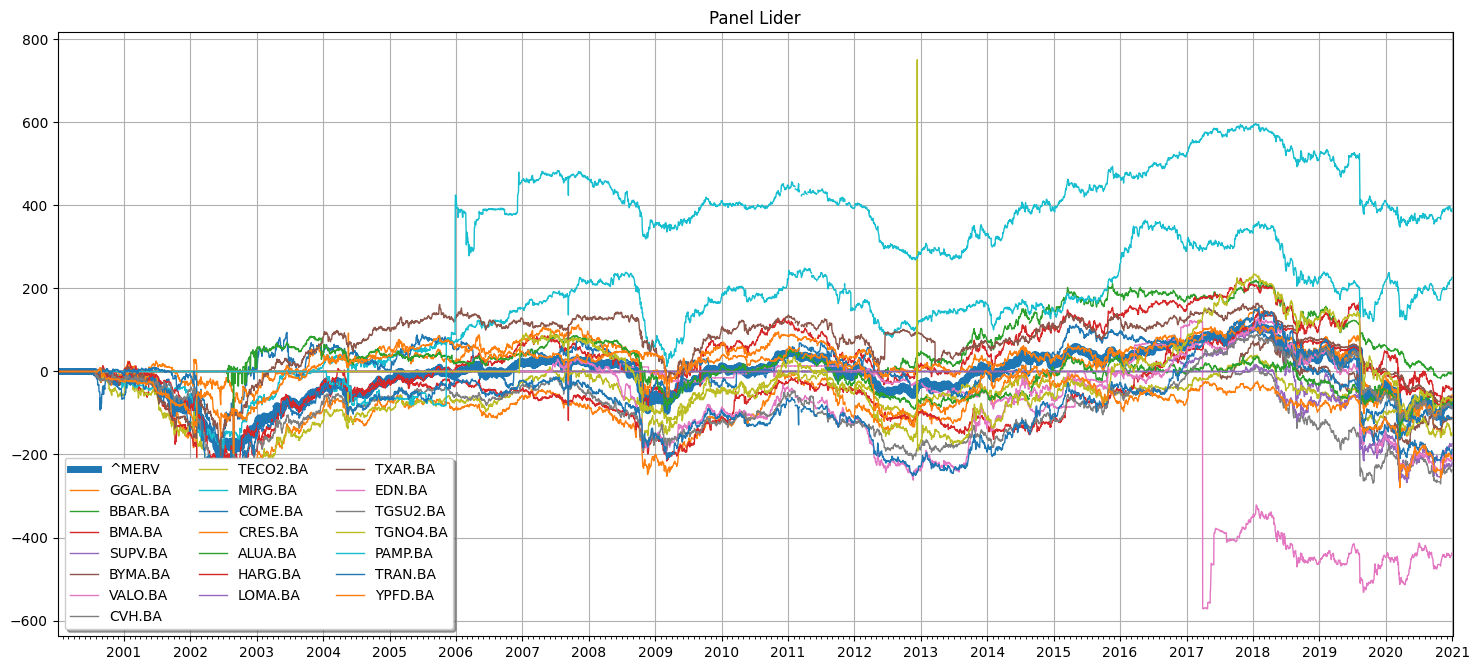

In [158]:
# Graficar la serie
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
#ax.plot(df_ccl)
# create a color palette
#palette = plt.get_cmap('Set1')
# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlim(np.datetime64(start), np.datetime64(end))
ax.grid(True)
#plt.style.use('seaborn-darkgrid')
num = 0
for t in panel_lider:
  num+1
  if t == '^MERV':
    ax.plot(df_ccl[t], label=t, lw=5)
  else:
    ax.plot(df_ccl[t], label=t, lw=1)
plt.title('Panel Lider')
#ax.legend(loc='best')
ax.legend(loc='lower left', ncol=3, fancybox=True, shadow=True)
#plt.savefig(ticker+".png")
plt.show()